# FENE beadspring with variable kuhn length experiment data analysis

In [53]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
import scipy.optimize
import functools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style("darkgrid")

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [4]:
pandarallel.initialize(
    nb_workers=len(os.sched_getaffinity(0)),
    progress_bar=False,
    use_memory_fs=False
)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read and process data

In [5]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212"
NAME_EC = "4-FENE-beadspring-vary-l_K.toml"
CONTINUE = True
CONTINUE_t_equilibrium = 45000000

In [6]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [11]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='72:00:00', partition='romeo', nodes=8, tasks_per_node=128, ntasks=1024, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=8, n_tasks_per_partition=128, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'n_relax_steps': 33000000, 'n_equilibrium_steps': 10000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s461

In [12]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

### Read initial system

In [13]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,-0.159927,-0.017451,-0.956566,0,0,0
3,1,2,-0.086992,-0.765936,-0.343908,0,0,0
4,1,2,0.059319,0.029401,-0.879569,0,0,0
5,1,2,0.514538,0.823298,-0.558005,0,0,0
...,...,...,...,...,...,...,...,...
25596,200,2,-10.247604,-9.443705,1.107040,0,0,0
25597,200,2,-10.923059,-9.000052,1.643541,0,0,0
25598,200,2,-10.288177,-8.437497,1.173056,0,0,0
25599,200,2,-10.067385,-8.446238,2.117553,0,0,0


In [14]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
25396,1,25595,25596
25397,1,25596,25597
25398,1,25597,25598
25399,1,25598,25599


In [15]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
25196,1,25594,25595,25596
25197,1,25595,25596,25597
25198,1,25596,25597,25598
25199,1,25597,25598,25599


In [16]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read and process trajectories

In [17]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/e296c212/data/processed/continue/trajectory_unfolded_kappas.csv')

In [18]:
def read_and_process_kappas_df(experiment_path: pathlib.Path, kappas: list[float]):
    dfs = []
    for i in range(1, len(kappas) + 1):
        paths_trajectories = [
            experiment_path / "data" / f"polymer_relax-{i}.out",
            experiment_path / "data" / f"polymer-{i}.out"
        ]

        if CONTINUE:
            paths_trajectories = [
                experiment_path / "data" / f"polymer_relax-{i}-continue.out",
                experiment_path / "data" / f"polymer-{i}-continue.out"
            ]


        print(f"Reading {paths_trajectories}...")
        if not all(p.exists() for p in paths_trajectories):
            break

        df_trajectory_unfolded = transform.unfold_coordinates_df(
            trajectory_df=transform.join_raw_trajectory_df_with_system_data(
                raw_trajectory_df=read.read_multiple_raw_trajectory_dfs(paths_trajectories),
                system_data=system
            ),
            system_data=system
        )
        df_trajectory_unfolded["kappa"] = kappas[i-1]
        dfs.append(df_trajectory_unfolded)

    return pd.concat(dfs)


if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = read_and_process_kappas_df(PATH_EXPERIMENT, kappas)
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
0,43000000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1,43000000,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1,1.0
2,43000000,3,2,-0.701293,0.727540,-1.291590,0,0,0,1,1.0
3,43000000,4,2,-1.130620,0.763959,-2.170250,0,0,0,1,1.0
4,43000000,5,2,-0.835501,1.059710,-1.273150,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
338329595,73000000,25596,2,-10.385500,-62.418300,-40.259700,0,0,0,200,36.0
338329596,73000000,25597,2,-10.388300,-63.451400,-40.145500,0,0,0,200,36.0
338329597,73000000,25598,2,-10.585800,-64.320000,-39.889900,0,0,0,200,36.0
338329598,73000000,25599,2,-10.851100,-65.139800,-39.646100,0,0,0,200,36.0


In [19]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
1.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
6.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
11.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
16.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
21.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
26.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
31.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0
36.0,42291200.0,6.412893e+07,6.122232e+06,43000000.0,60617500.0,64745000.0,68872500.0,73000000.0


## Calculate and plot observables relax+equi

In [21]:
l_b_src = .97
L_src = l_b_src*(conf.initial_system_config.system_config.n_monomers-1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [22]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = df_trajectory_unfolded_kappas.groupby("kappa").apply(transform.calc_end_to_end_df)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x        R_y       R_z          R
kappa molecule-ID t                                                  
1.0   1           43000000   0.776292  -7.756560  -4.01698   8.769434
                  43100000  14.942900  -8.777460 -12.44610  21.336342
                  43200000   8.072580  -3.591510  -7.73194  11.740885
                  43300000  -2.883810  -1.662700  -5.75536   6.648692
                  43400000   5.961520   0.210006  -7.21247   9.359677
...                               ...        ...       ...        ...
36.0  200         72960000 -13.669800 -58.464600 -44.21120  74.562746
                  72970000 -17.080400 -61.247900 -46.43560  78.735699
                  72980000 -17.119400 -63.686400 -44.13480  79.353084
                  72990000 -18.501500 -62.813600 -44.44030  79.137817
                  73000000 -10.890900 -66.065100 -39.44010  77.709270

[2641600 rows x 4 columns]

In [23]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x        R_y       R_z          R  \
kappa molecule-ID t                                                     
1.0   1           43000000   0.776292  -7.756560  -4.01698   8.769434   
                  43100000  14.942900  -8.777460 -12.44610  21.336342   
                  43200000   8.072580  -3.591510  -7.73194  11.740885   
                  43300000  -2.883810  -1.662700  -5.75536   6.648692   
                  43400000   5.961520   0.210006  -7.21247   9.359677   
...                               ...        ...       ...        ...   
36.0  200         72960000 -13.669800 -58.464600 -44.21120  74.562746   
                  72970000 -17.080400 -61.247900 -46.43560  78.735699   
                  72980000 -17.119400 -63.686400 -44.13480  79.353084   
                  72990000 -18.501500 -62.813600 -44.44030  79.137817   
                  73000000 -10.890900 -66.065100 -39.44010  77.709270   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           43000000  107500.0    76.902981  
                  43100000  107750.0   455.239470  
                  43200000  108000.0   137.848388  
                  43300000  108250.0    44.205100  
                  43400000  108500.0    87.603547  
...                              ...          ...  
36.0  200         72960000  182400.0  5559.603091  
                  72970000  182425.0  6199.310266  
                  72980000  182450.0  6296.911972  
                  72990000  182475.0  6262.794111  
                  73000000  182500.0  6038.730629  

[2641600 rows x 6 columns]

In [24]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa t                               
1.0   43000000   241.854962   1.854017
      43100000   243.443637   1.854017
      43200000   237.512198   1.854017
      43300000   236.844783   1.854017
      43400000   240.927077   1.854017
...                     ...        ...
36.0  72960000  6020.383608  68.870000
      72970000  6055.454135  68.870000
      72980000  6043.288356  68.870000
      72990000  6055.318675  68.870000
      73000000  6108.701851  68.870000

[13208 rows x 2 columns]

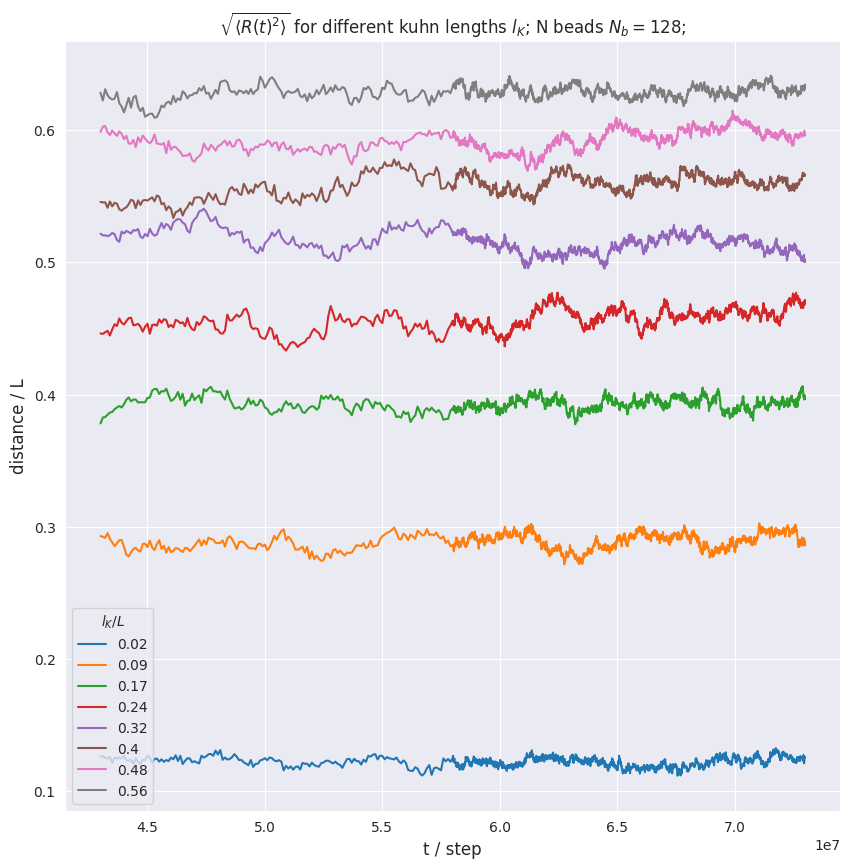

In [26]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [27]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

45000000

In [28]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
537600,45100000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
537601,45100000,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1,1.0
537602,45100000,3,2,-0.402514,0.518453,-1.761030,0,0,0,1,1.0
537603,45100000,4,2,-1.156770,0.656762,-2.264140,0,0,0,1,1.0
537604,45100000,5,2,-1.854480,1.367690,-2.332430,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
338329595,73000000,25596,2,-10.385500,-62.418300,-40.259700,0,0,0,200,36.0
338329596,73000000,25597,2,-10.388300,-63.451400,-40.145500,0,0,0,200,36.0
338329597,73000000,25598,2,-10.585800,-64.320000,-39.889900,0,0,0,200,36.0
338329598,73000000,25599,2,-10.851100,-65.139800,-39.646100,0,0,0,200,36.0


In [29]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x        R_y        R_z          R  \
kappa molecule-ID t                                                      
1.0   1           45000000  -9.783930   3.602560  -4.254920  11.260909   
                  45100000  -0.095306   7.968880  -4.678920   9.241451   
                  45200000   4.012900  -5.226490   2.654530   7.103949   
                  45300000   6.665830  -3.127390   0.727328   7.398842   
                  45400000   0.573610   0.799777  -3.583060   3.715776   
...                               ...        ...        ...        ...   
36.0  200         72960000 -13.669800 -58.464600 -44.211200  74.562746   
                  72970000 -17.080400 -61.247900 -46.435600  78.735699   
                  72980000 -17.119400 -63.686400 -44.134800  79.353084   
                  72990000 -18.501500 -62.813600 -44.440300  79.137817   
                  73000000 -10.890900 -66.065100 -39.440100  77.709270   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           45000000  112500.0   126.808069  
                  45100000  112750.0    85.404424  
                  45200000  113000.0    50.466094  
                  45300000  113250.0    54.742864  
                  45400000  113500.0    13.806991  
...                              ...          ...  
36.0  200         72960000  182400.0  5559.603091  
                  72970000  182425.0  6199.310266  
                  72980000  182450.0  6296.911972  
                  72990000  182475.0  6262.794111  
                  73000000  182500.0  6038.730629  

[2609600 rows x 6 columns]

In [30]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa t                               
1.0   45100000   238.838595   1.854017
      45200000   225.444953   1.854017
      45300000   234.975489   1.854017
      45400000   236.317922   1.854017
      45500000   227.754941   1.854017
...                     ...        ...
36.0  72960000  6020.383608  68.870000
      72970000  6055.454135  68.870000
      72980000  6043.288356  68.870000
      72990000  6055.318675  68.870000
      73000000  6108.701851  68.870000

[13040 rows x 2 columns]

### Mean bond length

In [31]:
l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=t_equilibrium)
l_b_df


KeyboardInterrupt



In [ ]:
l_b_df.groupby("kappa").describe()

In [33]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [34]:
L_contour = l_b*(conf.initial_system_config.system_config.n_monomers-1)
L_contour

123.19

### Kuhn lengths

Svaneborg (8)

In [35]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

In [36]:
l_ks / L_contour

array([0.01505006, 0.08662114, 0.16535433, 0.24409449, 0.32283465,
       0.4015748 , 0.48031496, 0.55905512])

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [37]:
N_Ks = (L_contour / l_ks)
N_Ks

array([66.44491561, 11.54452591,  6.04761901,  4.09677419,  3.09756098,
        2.49019608,  2.08196721,  1.78873239])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [38]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

,R^2
kappa,
1.0,226.252480
6.0,1270.912248
11.0,2344.056761
16.0,3191.379947
21.0,3999.379952
26.0,4760.692755
31.0,5336.683944
36.0,6006.719433


### Summarize statistics by kappas

In [39]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

,R^2,N_K,l_K
kappa,,,
1.0,226.252480,66.444916,1.854017
6.0,1270.912248,11.544526,10.670858
11.0,2344.056761,6.047619,20.370000
16.0,3191.379947,4.096774,30.070000
21.0,3999.379952,3.097561,39.770000
26.0,4760.692755,2.490196,49.470000
31.0,5336.683944,2.081967,59.170000
36.0,6006.719433,1.788732,68.870000


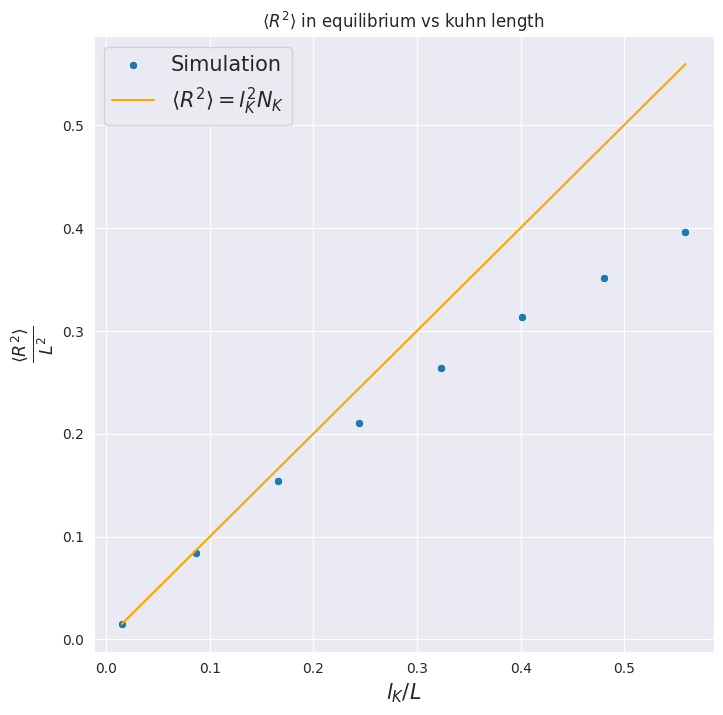

In [40]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * N_Ks) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [41]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
1.0     1.009476
6.0     1.034330
11.0    1.070529
16.0    1.160728
21.0    1.225006
26.0    1.280110
31.0    1.365858
36.0    1.412434
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [42]:
df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
df_ete_change_kappas_equi

,dR^2,kappa,l_K
t,,,
45000000,0.000000,1.0,1.854017
45100000,87.022290,1.0,1.854017
45200000,117.576237,1.0,1.854017
45300000,148.338726,1.0,1.854017
45400000,159.677072,1.0,1.854017
...,...,...,...
72960000,5979.480275,36.0,68.870000
72970000,6007.654671,36.0,68.870000
72980000,6013.959366,36.0,68.870000


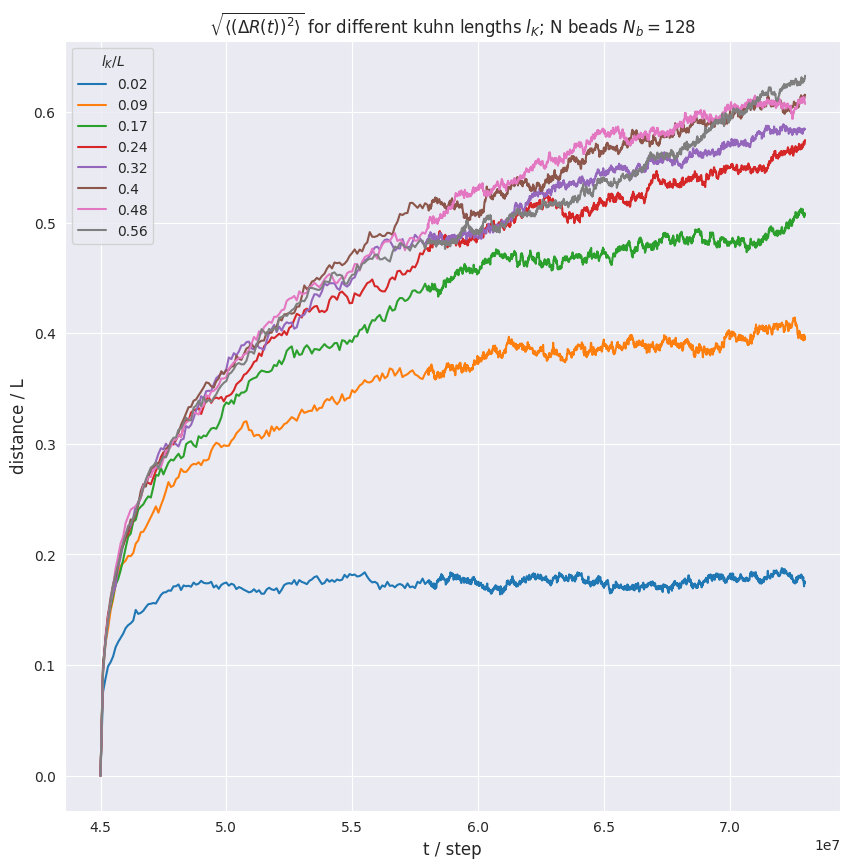

In [44]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Compare with Rouse model

### Transform time

In [45]:
df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi.index.get_level_values("t").map(lambda t: t*0.0025)
df_ete_change_kappas_equi["t/LJ rescaled"] = df_ete_change_kappas_equi["t/LJ"]-df_ete_change_kappas_equi["t/LJ"].min()
df_ete_change_kappas_equi

,dR^2,kappa,l_K,t/LJ,t/LJ rescaled
t,,,,,
45000000,0.000000,1.0,1.854017,112500.0,0.0
45100000,87.022290,1.0,1.854017,112750.0,250.0
45200000,117.576237,1.0,1.854017,113000.0,500.0
45300000,148.338726,1.0,1.854017,113250.0,750.0
45400000,159.677072,1.0,1.854017,113500.0,1000.0
...,...,...,...,...,...
72960000,5979.480275,36.0,68.870000,182400.0,69900.0
72970000,6007.654671,36.0,68.870000,182425.0,69925.0
72980000,6013.959366,36.0,68.870000,182450.0,69950.0


### Analytical $\tau_R$

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta_K N_K l_K^2}{k_B T} = \frac{1}{3 \pi^2} \frac{\zeta N_b N_K l_K^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_K^2} $$

In [51]:
zeta = 1  # LJ
T = 1
k_B = 1
alpha = 4.047

rouse_times_analytical = []
for i, (l_K, N_K, R_sq) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"], df_kuhn_summary["R^2"])):
    tau_R_analytical = zeta*conf.initial_system_config.system_config.n_monomers*N_K*l_K**2 / (3*np.pi**2*k_B*T)
    tau_R_analytical_corrected = tau_R_analytical*alpha
    rouse_times_analytical.append(tau_R_analytical_corrected)

df_rouse_times_theory = pd.DataFrame({
    "l_K": df_kuhn_summary["l_K"],
    "N_K": df_kuhn_summary["N_K"],
    "Theory tau_R": rouse_times_analytical,
    "Theory tau_0": rouse_times_analytical / df_kuhn_summary["N_K"]**2
}, index=df_kuhn_summary.index)

df_rouse_times_theory

,l_K,N_K,Theory tau_R,Theory tau_0
kappa,,,,
1.0,1.854017,66.444916,3995.869812,0.905082
6.0,10.670858,11.544526,22998.366031,172.561845
11.0,20.370000,6.047619,43902.440294,1200.382939
16.0,30.070000,4.096774,64808.363827,3861.419656
21.0,39.770000,3.097561,85714.287643,8933.332353
26.0,49.470000,2.490196,106620.211458,17193.822928
31.0,59.170000,2.081967,127526.135273,29420.593301
36.0,68.870000,1.788732,148432.059088,46391.345394


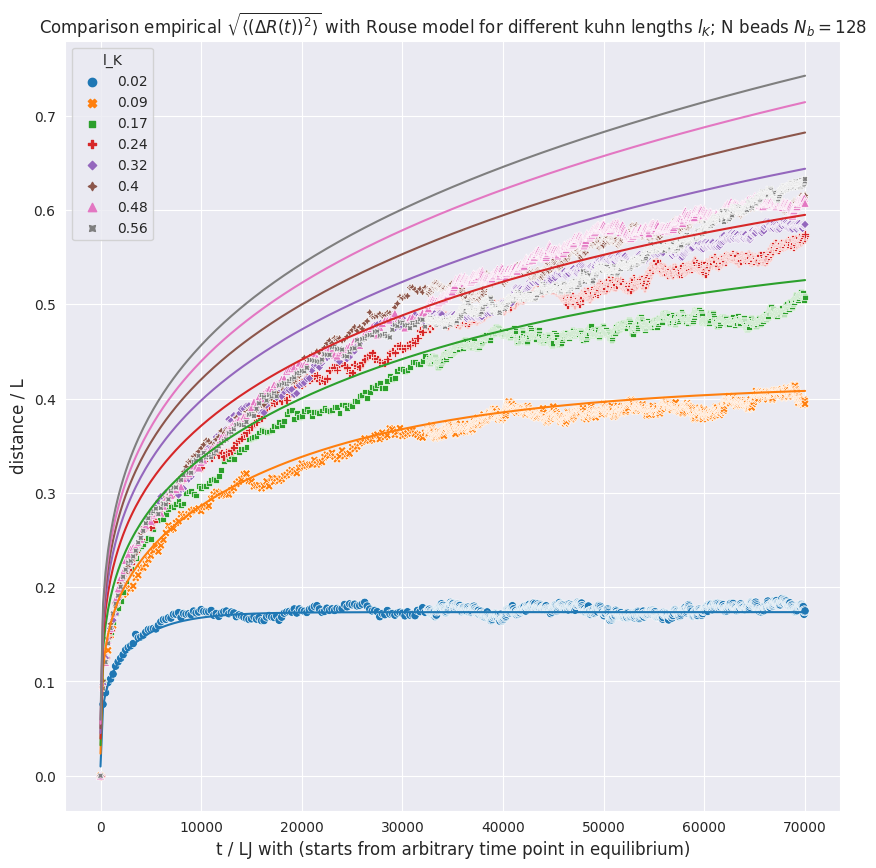

In [61]:
import matplotlib.legend

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'Comparison empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ with Rouse model for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ rescaled"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

lines = []
labels = []

for i, (l_K, N_K, tau_R) in enumerate(zip(df_rouse_times_theory["l_K"], df_rouse_times_theory["N_K"], df_rouse_times_theory["Theory tau_R"])):
    ts = df_ete_change_kappas_equi["t/LJ rescaled"].unique()

    rouse_predictions = rouse.rouse_g_4(
        t=ts,
        tau_R=tau_R,
        p_max=conf.initial_system_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K
    )
    line = ax.plot(
        ts,
        np.sqrt(rouse_predictions) / L_contour,
        color=kappa_colors[i]
    )
    lines.append(line)
    labels.append(f"$\sqrt{{g_4(t)}}$ for $l_K/L = {np.round(l_K/L_contour, 2)}$")

### Fit $\tau_R$

In [64]:

df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.initial_system_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        df_ete_change_kappas_equi_kappa["dR^2"],
        p0=(10**(i+1),) if i!=0 else 100
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"]**2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit["N_K"]**2

df_rouse_times_fit

/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Empirical tau_R,Empirical Delta tau_R,l_K,N_K,Empirical tau_0,Empirical Delta tau_0
kappa,,,,,,
1.0,3379.654290,129.134876,1.854017,66.444916,0.765506,0.029250
6.0,27041.399132,83.080658,10.670858,11.544526,202.897620,0.623373
11.0,54020.702159,145.804636,20.370000,6.047619,1477.037012,3.986598
16.0,82612.291890,118.973884,30.070000,4.096774,4922.215420,7.088716
21.0,127463.023335,152.409964,39.770000,3.097561,13284.477787,15.884503
26.0,166985.101468,223.248318,49.470000,2.490196,26928.405290,36.001542
31.0,229181.936440,335.202482,59.170000,2.081967,52872.836846,77.332038
36.0,359543.934314,1162.273027,68.870000,1.788732,112372.805064,363.259863


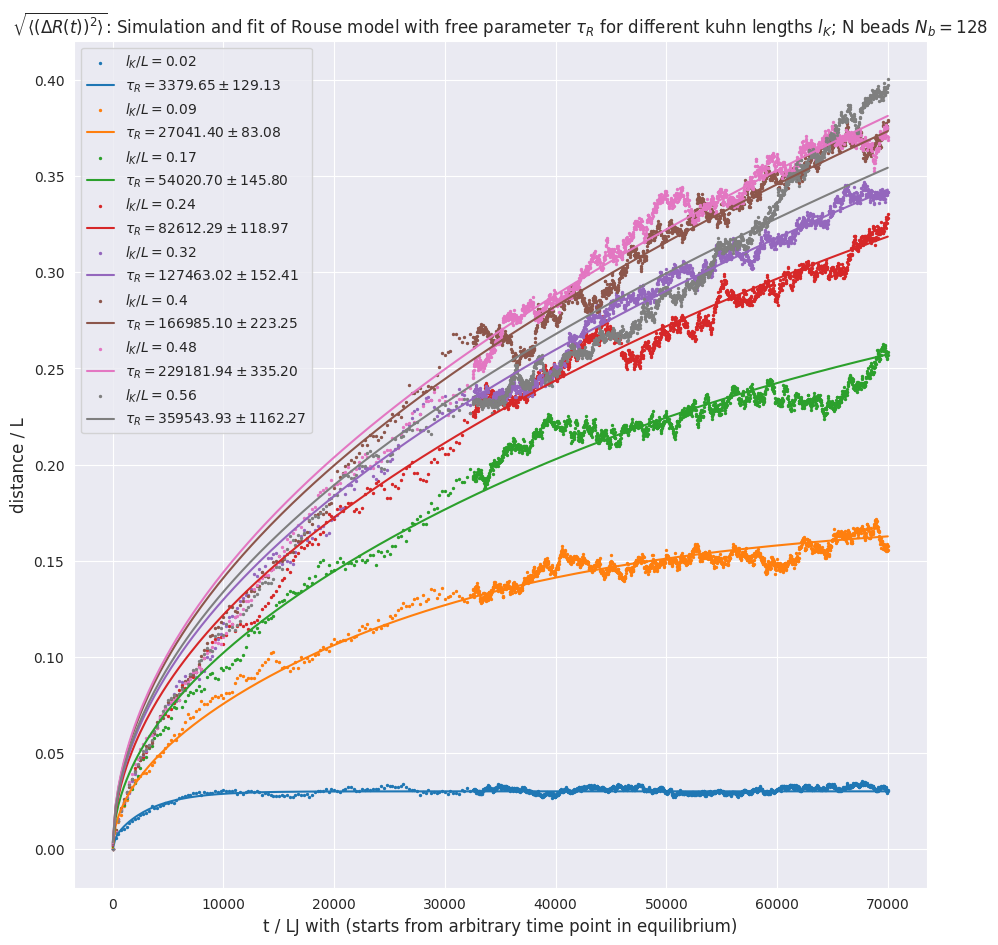

In [65]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(11,11))

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    ax.scatter(
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        df_ete_change_kappas_equi_kappa["dR^2"] / L_contour**2,
        label=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        #marker= list(matplotlib.markers.MarkerStyle.markers.keys())[i],
        color=kappa_colors[i],
        s=2
    )
    ax.plot(
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.initial_system_config.system_config.n_monomers,
            tau_R=tau_R
        ) / L_contour**2,
        label=f"$\\tau_R={tau_R:.2f} \pm {dtau_R:.2f}$",
        color=kappa_colors[i]
    )

ax.legend()

_ = ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

### Compare times

In [66]:
df_rouse_rimes = df_rouse_times_theory.join(df_rouse_times_fit.drop(["l_K", "N_K"], axis=1))
df_rouse_rimes

,l_K,N_K,Theory tau_R,Theory tau_0,Empirical tau_R,Empirical Delta tau_R,Empirical tau_0,Empirical Delta tau_0
kappa,,,,,,,,
1.0,1.854017,66.444916,3995.869812,0.905082,3379.654290,129.134876,0.765506,0.029250
6.0,10.670858,11.544526,22998.366031,172.561845,27041.399132,83.080658,202.897620,0.623373
11.0,20.370000,6.047619,43902.440294,1200.382939,54020.702159,145.804636,1477.037012,3.986598
16.0,30.070000,4.096774,64808.363827,3861.419656,82612.291890,118.973884,4922.215420,7.088716
21.0,39.770000,3.097561,85714.287643,8933.332353,127463.023335,152.409964,13284.477787,15.884503
26.0,49.470000,2.490196,106620.211458,17193.822928,166985.101468,223.248318,26928.405290,36.001542
31.0,59.170000,2.081967,127526.135273,29420.593301,229181.936440,335.202482,52872.836846,77.332038
36.0,68.870000,1.788732,148432.059088,46391.345394,359543.934314,1162.273027,112372.805064,363.259863


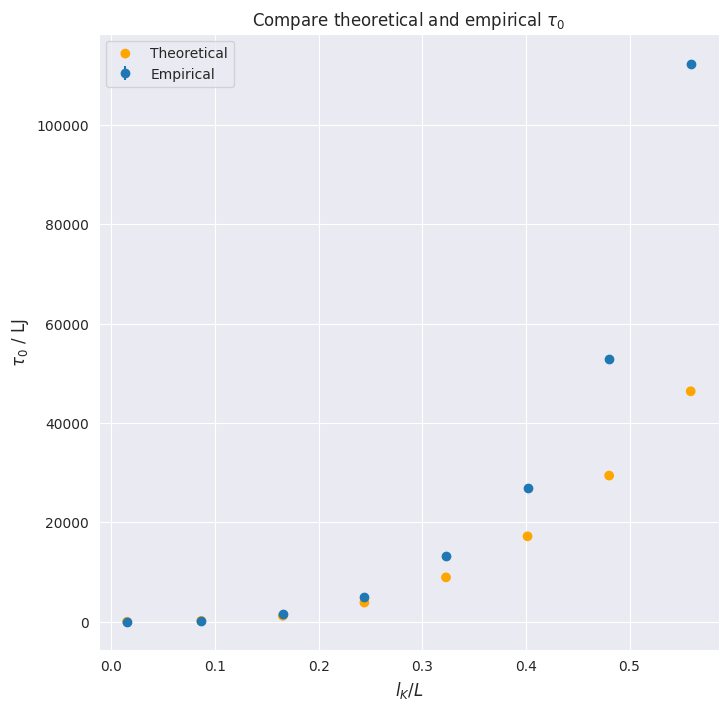

In [78]:
import matplotlib.container
import matplotlib.collections

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8,8))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\tau_0$ / LJ",
    title="Compare theoretical and empirical $\\tau_0$"
)

path_coll: matplotlib.collections.PathCollection = ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Theory tau_0"],
    linestyle="",
    marker="o",
    label="Theoretical",
    color="orange",
)

ax.legend()